In [5]:
# Importing libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [59]:
# Setting plot preferences

# plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
       'weight'  : 'bold',
       'size'    : 14}

mpl.rc('font', **font)

In [68]:
sns.set(style = 'whitegrid', palette='bright', rc = {'figure.figsize':(14,6)})

**Roadmap for the test**
- current conversion rate of 13% -> expected 15%
- alpha value : 0.05
- power of the test : 0.8

Calculating expected sample size to measure significance of the test

In [8]:
#calculating effect size based on expected rates = 13% VS. 15%
effect_size = sms.proportion_effectsize(0.13, 0.15)

#calculating sample size needed
required_n = sms.NormalIndPower().solve_power(effect_size,
                                              power=0.8,
                                              alpha=0.05,
                                              ratio=1)

#rounding up to whole number
required_n = ceil(required_n)

print(required_n)

4720


Importing dataset from [Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv)

In [2]:
data = pd.read_csv(r'data/ab_data.csv')

In [3]:
data

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [12]:
#checking differences between control group & test_group
pd.crosstab(data['group'], data['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [13]:
#check whether no user have been sampled multiple times

In [28]:
session_counts = data['user_id'].value_counts()
multi_users = session_counts[session_counts > 1].count()

print(f"there are {multi_users} users who have been sampled multiple times. An action must be taken : remove all \
or Keep only One session for each multiple users")

there are 3894 users who have been sampled multiple times. An action must be taken : remove all or Keep only One session for each multiple users


In [29]:
#removing all multiple users

In [32]:
users_to_drop = session_counts[session_counts >1].index

data = data[~data['user_id'].isin(users_to_drop)]

print(f'updated dataframe has {data.shape[0]} rows')

updated dataframe has 286690 rows


**Sampling A/B testing data**

In [39]:
control_group = data[data['group'] == 'control'].sample(n=required_n, random_state=22)

test_group = data[data['group'] == 'treatment'].sample(n=required_n, random_state=22)

In [45]:
ab_test = pd.concat([control_group, test_group], axis=0).reset_index(drop=True)

In [46]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [47]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
user_id         9440 non-null int64
timestamp       9440 non-null object
group           9440 non-null object
landing_page    9440 non-null object
converted       9440 non-null int64
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [49]:
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [52]:
# To measure AB test impact & evolution of the conversion rate, we would need to measure 
# the mean, standard deviation and std error of the two population
# creating lambda function std deviation & std error to apply to the groupby

In [53]:
# lambda standard deviation
std_pop = lambda x:np.std(x, ddof=0)

# lambda standard error
ste_pop = lambda x:stats.sem(x, ddof=0)

In [ ]:
# using lambda functions to the group by

In [55]:
conversion_rate = ab_test.groupby('group')['converted'].agg([np.mean, std_pop, ste_pop])

conversion_rate.columns = ['cr_mean','cr_std', 'cr_ste']

conversion_rate.style.format('{:.3f}')

,cr_mean,cr_std,cr_ste
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Very similar performance between 2 groups :
- treatment group's conversion rate perfrom 12.6% VS. 12.3% from control group

In [56]:
# plotting data

Text(0, 0.5, 'conversion rate')

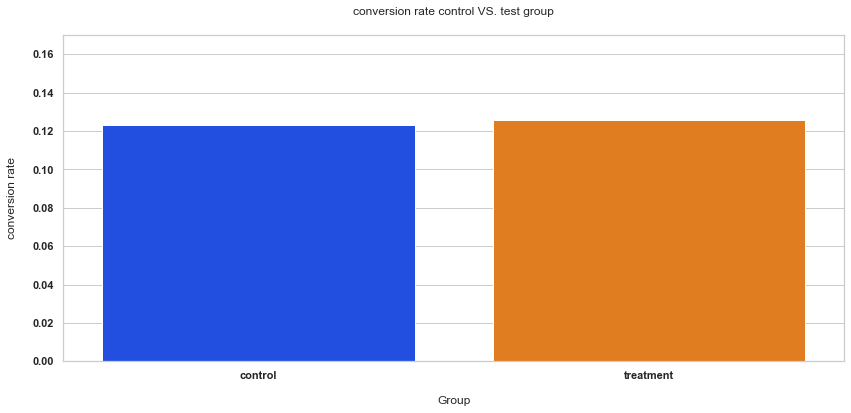

In [69]:
sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('conversion rate control VS. test group', pad=20)
plt.xlabel('Group',labelpad=15)
plt.ylabel('conversion rate', labelpad=15)

**Testing the hypothesis with p-value**

In [70]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [73]:
control_results = ab_test[ab_test['group'] == 'control']['converted']

test_group_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [74]:
n_con = control_results.count()
n_treat = test_group_results.count()

successes = [control_results.sum(), test_group_results.sum()]
n_obs = [n_con, n_treat]

In [76]:
z_stat, p_val = proportions_ztest(count=successes, nobs=n_obs)

In [80]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=n_obs, alpha=0.05)

In [88]:
print(f'z stat: {z_stat:.2f}')
print(f'p_value:{p_val:.3f}')

print(f'confidence interval of 95% for control group : [{lower_con:.3f}, {upper_con:.3f}]')

print(f'confidence interval of 95% for test group : [{lower_treat:.3f}, {upper_treat:.3f}]')

z stat: -0.34
p_value:0.732
confidence interval of 95% for control group : [0.114, 0.133]
confidence interval of 95% for test group : [0.116, 0.135]


In [78]:
p_val

0.7316316123467367

In [79]:
z_stat

-0.342955932739339